# Chapter 2 - End-to-end Machine Learning project

Inspired by https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

In [105]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn import set_config

## Data import

The California Housing dataset contains data from the 1990 US census for 20,640 Californian districts.
The dependent variable is the house median value in each district.
The 9 independent variables are longitude, latitude, house median age, total rooms, total bedrooms, population, households, median income and ocean proximity.

Source: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

In [23]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    import tarfile
    import urllib.request
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [24]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [27]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Stratified train-test split

To ensure train and test data come from the same distribution we'll control for the median income (we expect it to be an important predictor) when splitting the data into train and test set.

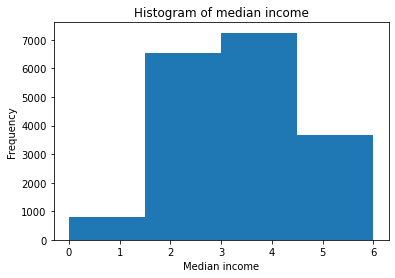

In [42]:
plt.hist(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf])
plt.xlabel('Median income')
plt.ylabel('Frequency')
plt.title('Histogram of median income')
plt.show()

In [46]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [36]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [37]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Pre-processing pipeline

1. Pre-processing of numeric features 
    - Imputation of missing values using median
    - Calculate new features
    - Standard scaling of features
2. Pre-processing of categorical features
    - Imputation of missing values using mode
    - One-hot encoding
3. Add missing value indicator feature

In [47]:
housing = strat_train_set.copy()
X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

In [54]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    This transformer calculates some additional features:
    - rooms_per_household
    - population_per_household
    and optionally bedrooms_per_room if the hyperparameter
    add_bedrooms_per_room=True.
    This is to show how custom transformers can be defined
    with hyperparameters so they can be tuned by adding it
    to param_grid.
    """
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self
    def transform(self, X):
        rix, bix, pix, hix = [num_cols.index(e) for e in ['total_rooms', 'total_bedrooms', 'population', 'households']]
        rooms_per_household = X[:, rix] / X[:, hix]
        population_per_household = X[:, pix] / X[:, hix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bix] / X[:, rix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    def get_feature_names_out(self, input_features=None):
        feature_names = input_features + ['rooms_per_household', 'population_per_household']
        if self.add_bedrooms_per_room:
            feature_names.extend(['bedrooms_per_room'])
        return np.asarray(feature_names, dtype=object)

In [60]:
num_cols = ['longitude', 'latitude', 'housing_median_age',
            'total_rooms', 'total_bedrooms', 'population',
            'households', 'median_income']
cat_cols = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
        ,('attribs_adder', CombinedAttributesAdder())
        ,('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ,('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])

miss_indicator = Pipeline(steps=[
    ('add_ind', MissingIndicator())
])

preproc = ColumnTransformer([
    ("num", num_pipeline, num_cols)
    ,("cat", cat_pipeline, cat_cols)
    ,('missing', miss_indicator, num_cols+cat_cols)
], remainder = 'passthrough')

I define a custom function to get the feature names out from a ColumnTransformer, so I can conveniently inspect it as a data frame.

In [56]:
def get_names_out_from_ColumnTransformer(column_transformer, df=None, verbose=False):
    """
    Returns a list of the feature names produced by a Column Transformer
    It should probably do the same as the ColumnTransformer method get_feature_names_out() 
    but it didn't work for me
    column_transformer: an instance of a fitted Column Transformer;
                        the second element of each tuple must be a Pipeline, not a transformer
    df: the dataframe passed to the fit method of a Column Transformer 
        (only needed if remainder step has passthrough strategy)
    """
    from sklearn.utils.validation import check_is_fitted
    check_is_fitted(column_transformer)
    col_names = []
    # column_transformer.transformers_ is a list of tuples
    # each tuple (outer_pipeline) has three elements: 
    # name of the pipeline -> outer_pipeline[0]
    # the fitted pipeline -> outer_pipeline[1]
    # list of features fed into the pipeline -> outer_pipeline[2]
    for outer_pipeline in [p for p in column_transformer.transformers_ if p[0] != 'remainder']:
        features_in = outer_pipeline[2]
        if verbose: print(f"features in '{outer_pipeline[0]}': {features_in}")
        for inner_pipeline_step in outer_pipeline[1].steps:
            if verbose: print(f"  features in '{inner_pipeline_step[0]}': {features_in}")
            # inner_pipeline_step is a tuple of two elements
            # name of the transformer -> inner_pipeline_step[0]
            # the fitted transformer -> inner_pipeline_step[1]
            transformer = inner_pipeline_step[1]
            if hasattr(transformer, 'get_feature_names_out'):
                features_out = transformer.get_feature_names_out(features_in).tolist()
            else:
                # if a transformer doesn't have get_feature_names_out method
                # features in = features out
                features_out = features_in
            # if an imputer has add_indicator=True make a name for it
            if hasattr(transformer, 'indicator_') \
            and transformer.indicator_ is not None:
                features_out += [features_in[i] + '_missing' for i in transformer.indicator_.features_]
            if isinstance(transformer, MissingIndicator):
                features_out = [features_in[i] + '_missing' for i in transformer.features_]    
            # features_out is features_in for the next inner_pipeline_step
            features_in = features_out
            if verbose: print(f"  features out '{inner_pipeline_step[0]}': {features_in}")
        col_names.extend(features_out)
    # add passthrough-ed columns
    if 'remainder' in column_transformer.named_transformers_.keys() \
    and column_transformer.named_transformers_['remainder'] == 'passthrough':
        assert df is not None, "df is None"
        remainder = column_transformer.transformers_[-1]
        passthrough_features = df.columns[remainder[2]].tolist()
        col_names.extend(passthrough_features)
    return col_names

In [61]:
pd.DataFrame(preproc.fit_transform(X_train),
             columns=get_names_out_from_ColumnTransformer(preproc, X_train),
             index=X_train.index).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,total_bedrooms_missing
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.017395,0.006223,-0.121122,0.0,1.0,0.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.569256,-0.040811,-0.810867,0.0,0.0,0.0,0.0,1.0,0.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.018024,-0.075371,-0.338273,0.0,1.0,0.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.595140,-0.106803,0.961205,0.0,0.0,0.0,0.0,1.0,0.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.251241,0.006109,-0.474513,1.0,0.0,0.0,0.0,0.0,0.0


## Full pipeline

1. Pre-processing
2. Feature selection using Lasso
3. Random Forest regression model

In [111]:
full_pipeline = Pipeline([
    ("pre", preproc)
    ,('feat_sel', SelectFromModel(LassoCV(), threshold=0.25))
    ,("fit", RandomForestRegressor(random_state=42))
])

## Grid Search

In [112]:
%%time
param_grid = [
    {'pre__num__attribs_adder__add_bedrooms_per_room': [False], 'fit__n_estimators': [3, 10, 30], 'fit__max_features': [2, 4, 6, 8]},
    {'fit__bootstrap': [False], 'fit__n_estimators': [3, 10], 'fit__max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           verbose=3)
grid_search.fit(X_train, y_train)
final_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END fit__max_features=2, fit__n_estimators=3, pre__num__attribs_adder__add_bedrooms_per_room=False;, score=(train=-1101864977.854, test=-3949361811.783) total time=   0.3s
[CV 2/5] END fit__max_features=2, fit__n_estimators=3, pre__num__attribs_adder__add_bedrooms_per_room=False;, score=(train=-1102353160.277, test=-3932484525.958) total time=   0.3s
[CV 3/5] END fit__max_features=2, fit__n_estimators=3, pre__num__attribs_adder__add_bedrooms_per_room=False;, score=(train=-1091761528.866, test=-3963941631.864) total time=   0.3s
[CV 4/5] END fit__max_features=2, fit__n_estimators=3, pre__num__attribs_adder__add_bedrooms_per_room=False;, score=(train=-1085048635.876, test=-4583772385.596) total time=   0.3s
[CV 5/5] END fit__max_features=2, fit__n_estimators=3, pre__num__attribs_adder__add_bedrooms_per_room=False;, score=(train=-1104422783.731, test=-4014944168.091) total time=   0.2s
[CV 1/5] END fit__max_features=2, 

## Model evaluation

In [113]:
set_config(display="diagram")
final_model

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder(add_bedrooms_per_room=False)),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'househol...
                                                  ['ocean_proximity']),
                                                 ('missing',
                                                  Pipeline(steps=[('add_ind',
                                                                   MissingIndicator())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'ocean_proximity'])])),
                ('feat_sel',
                 SelectFromModel(estimator=LassoCV(), threshold=0.25)),
                ('fit',
                 RandomForestRegressor(max_features=6, n_estimators=30,
                                       random_state=42))])

In [114]:
feat_selected_mask = final_model.named_steps['feat_sel'].get_support()
feature_names = get_names_out_from_ColumnTransformer(final_model.named_steps['pre'], X_train)
feat_selected = np.array(feature_names)[feat_selected_mask]
feat_imps = final_model.named_steps['fit'].feature_importances_
print("Feature importances:")
for k,v in sorted(zip(feat_selected, feat_imps), key = lambda x: x[1], reverse=True):
    print(f"{k} {v:.2f}")

Feature importances:
median_income 0.37
ocean_proximity_INLAND 0.16
population_per_household 0.11
rooms_per_household 0.08
latitude 0.08
longitude 0.08
housing_median_age 0.04
total_rooms 0.02
population 0.02
households 0.02
total_bedrooms 0.02
ocean_proximity_NEAR OCEAN 0.00
ocean_proximity_NEAR BAY 0.00


In [100]:
train_preds = final_model.predict(X_train)
train_rmse = mean_squared_error(y_train, train_preds, squared=False)

train_errors = (train_preds - y_train) ** 2
train_ci = np.sqrt(stats.t.interval(0.95, len(train_errors) - 1,
                                    loc=train_errors.mean(),
                                    scale=stats.sem(train_errors)))

print(f"Train error: {train_rmse:,.0f} [{train_ci[0]:,.0f}-{train_ci[1]:,.0f}]")

Train error: 19,217 [18,760-19,662]


In [118]:
%%time
cv_scores = cross_val_score(final_model, X_train, y_train,
                            scoring="neg_mean_squared_error", cv=10)
validation_rmse = np.sqrt(-np.mean(cv_scores))
print(f"Validation error: {validation_rmse:,.0f}")

Validation error: 49,559
CPU times: user 23 s, sys: 12.4 s, total: 35.4 s
Wall time: 15.2 s


In [102]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [103]:
test_preds = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

test_errors = (test_preds - y_test) ** 2
test_ci = np.sqrt(stats.t.interval(0.95, len(test_errors) - 1,
                                   loc=test_errors.mean(),
                                   scale=stats.sem(test_errors)))

print(f"Test error: {test_rmse:,.0f} [{test_ci[0]:,.0f}-{test_ci[1]:,.0f}]")

Test error: 47,511 [45,535-49,407]
